In [5]:
import cv2
import io
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [6]:
def get_images(image_name,pixel_density=(1920,1080)):
    T=cv2.imread(image_name)
    #gray_img=cv2.cvtColor(color_img,cv2.COLOR_RGB2GRAY)
    # T=cv2.cvtColor(T,cv2.COLOR_BGR2GRAY)
    return cv2.resize(T,pixel_density,interpolation=cv2.INTER_AREA)

In [7]:
def im_show(im_temp):
    plt.imshow(im_temp)
    plt.show()

In [8]:
# 车道线提取
# 颜色空间转换——》边缘检测——》颜色阈值-》合并并且使用L通道进行白的区域的抑制
def pipeline(img, s_thresh=(170, 255), sx_thresh=(40, 200)):
    # 复制原图像
    img = np.copy(img)
    # 颜色空间转换
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float64)
    l_chanel = hls[:, :, 1]
    s_chanel = hls[:, :, 2]
    # sobel边缘检测
    # sobelx = cv2.Sobel(l_chanel, cv2.CV_64F, 1,1,ksize=3)
    sobelx=cv2.Canny(img,180,255)
    
    
    return sobelx

In [9]:
# 获取透视变换的参数矩阵
def cal_perspective_params(img, points):
    offset_x = 330
    offset_y = 0
    img_size = (img.shape[1], img.shape[0])
    src = np.float32(points)
    # 设置俯视图中的对应的四个点
    dst = np.float32([[offset_x, offset_y], [img_size[0] - offset_x, offset_y],
                      [offset_x, img_size[1] - offset_y], [img_size[0] - offset_x, img_size[1] - offset_y]])
    # 原图像转换到俯视图
    M = cv2.getPerspectiveTransform(src, dst)
    # 俯视图到原图像
    M_inverse = cv2.getPerspectiveTransform(dst, src)
    return M, M_inverse

In [10]:
def img_perspect_transform(img, M):
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(img, M, img_size)

In [11]:
#给图片加黑边
#输入三通道图片
def widen_image(img,size):
    return cv2.copyMakeBorder(img,top=size,bottom=size,left=size,right=size, borderType=cv2.BORDER_CONSTANT,value=[0,0,0])

In [12]:
#拟合车道线
def cal_line_param(binary_warped):
    # 1.确定左右车道线的位置
    # 统计直方图
    histogram = np.sum(binary_warped[:, :], axis=0)
    # 在统计结果中找到左右最大的点的位置，作为左右车道检测的开始点
    # 将统计结果一分为二，划分为左右两个部分，分别定位峰值位置，即为两条车道的搜索位置
    midpoint = np.int64(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # print(leftx_base,rightx_base)
    # 2.滑动窗口检测车道线
    # 设置滑动窗口的数量，计算每一个窗口的高度
    nwindows = 3
    window_height = np.int64(binary_warped.shape[0] / nwindows)
    # 获取图像中不为0的点
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # 车道检测的当前位置
    leftx_current = leftx_base
    rightx_current = rightx_base
    # 设置x的检测范围，滑动窗口的宽度的一半，手动指定
    margin = 80
    # 设置最小像素点，阈值用于统计滑动窗口区域内的非零像素个数，小于50的窗口不对x的中心值进行更新
    minpix = 20
    # 用来记录搜索窗口中非零点在nonzeroy和nonzerox中的索引
    left_lane_inds = []
    right_lane_inds = []

    # 遍历该副图像中的每一个窗口
    for window in range(nwindows):
        # 设置窗口的y的检测范围，因为图像是（行列）,shape[0]表示y方向的结果，上面是0
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        # 左车道x的范围
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        # 右车道x的范围
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        
        # 确定非零点的位置x,y是否在搜索窗口中，将在搜索窗口内的x,y的索引存入left_lane_inds和right_lane_inds中
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # 如果获取的点的个数大于最小个数，则利用其更新滑动窗口在x轴的位置
        if len(good_left_inds) > minpix:
            leftx_current = np.int64(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int64(np.mean(nonzerox[good_right_inds]))

    # 将检测出的左右车道点转换为array
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # 获取检测出的左右车道点在图像中的位置
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # 3.用曲线拟合检测出的点,二次多项式拟合，返回的结果是系数
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

In [55]:
# 绘制车道线
def fill_lane_poly(img, left_fit, right_fit):
    # 获取图像的行数
    y_max = img.shape[0]
    # 设置输出图像的大小，并将白色位置设为255
    out_img = np.dstack((img, img, img)) 
    # 在拟合曲线中获取左右车道线的像素位置
    left_points = [[left_fit[0] * y ** 2 + left_fit[1] * y + left_fit[2], y] for y in range(y_max)]
    right_points = [[right_fit[0] * y ** 2 + right_fit[1] * y + right_fit[2], y] for y in range(y_max - 1, -1, -1)]
    # 将左右车道的像素点进行合并
    # line_points = np.vstack((left_points, right_points))
    # 根据左右车道线的像素位置绘制多边形
    # cv2.fillPoly(out_img, np.int_([line_points]), (0, 255, 0))
    # cv2.fillPoly(out_img,np.int_([left_points]),(0,255,0))
    # cv2.fillPoly(out_img,np.int_([right_points]),(0,255,0))

    line_color=(0,255,0)
    line_thickness=15
    # for i in range(len(line1_fit_points) - 1):
    #     cv2.line(img, line1_fit_points[i], line1_fit_points[i+1], color=line_color, thickness=line_thickness)
    # for i in range(len(line2_fit_points) - 1):
    #     cv2.line(img, line2_fit_points[i], line2_fit_points[i+1], color=line_color, thickness=line_thickness)

    left_points=np.int_(left_points)
    right_points=np.int_(right_points)

    for i in range(len(left_points)-1):
        cv2.line(out_img,left_points[i],left_points[i+1],color=line_color,thickness=line_thickness)
    for i in range(len(left_points)-1):
        cv2.line(out_img,right_points[i],right_points[i+1],color=line_color,thickness=line_thickness)


    return out_img

In [14]:
def image_curtail(img,widen_size):
    img=img[widen_size:-widen_size,widen_size:-widen_size]
    return img

In [15]:
def image_combine(img_orgin,im_fin):
    
    return cv2.addWeighted(img_orgin,1,im_fin,0.9,0)

In [16]:
def program(file_path,pixel_density=(320,240),widen_size=50,points=[]):
    im_original=get_images(file_path,pixel_density=pixel_density)
    # plt.figure()
    # plt.imshow(im_original)
    #图片加黑边
    im_widen=widen_image(im_original,size=widen_size)
    #高斯滤波
    im_gaussian=cv2.GaussianBlur(im_widen,(5,5),0.5,0.5)
    # plt.figure()
    # plt.imshow(im_gaussian)
    #图片处理
    im_pipeline=pipeline(im_gaussian)
    # plt.figure()
    # plt.imshow(im_pipeline)
    # points = [[601, 448], [683, 448], [230, 717], [1097, 717]]
    # points=[[300,190],[180,193],[399,271],[26,291]] #T_number=1
    M,M_inverse=cal_perspective_params(im_pipeline,points=points)
    im_perspect=img_perspect_transform(im_pipeline,M)
    
    # im_perspect_1=img_perspect_transform(im_perspect,M_inverse)
    # plt.figure()
    # plt.imshow(im_perspect)
    #拟合车道线
    left_fit,right_fit = cal_line_param(im_perspect)
    im=fill_lane_poly(im_perspect,left_fit,right_fit)
    # plt.figure()
    # plt.imshow(im)
    im_anti_perspect=img_perspect_transform(im,M_inverse)
    # plt.figure()
    # plt.imshow(im_anti_perspect)
    im_curtail=image_curtail(im_anti_perspect,widen_size=widen_size)
    im_finally=image_combine(im_original,im_curtail)
    return im_finally

In [37]:
save_path='./result/'
source_path='./picture/'
pixel_density=(1920,1080)
widen_size=50
# points=[[1172,659],[753,667],[1530,879],[421,852]]
# points=[[1189,687],[606,658],[1408,870],[295,841]]
# points=[[1189,787],[606,758],[1408,870],[295,841]]
# points=[[1000,600],[606,600],[1408,870],[295,841]]
points=[[1000,600],[750,600],[1408,870],[400,841]]
#17703
for i in tqdm(range(7249)):
    count_str = "%05d" % (i+10454)
    path=source_path+count_str+'.jpg'
    im_temp=program(file_path=path,pixel_density=pixel_density,widen_size=widen_size,points=points)
    cv2.imwrite(save_path+count_str+'.jpg',im_temp)
    pass
# plt.imshow(program(file_path=source_path,pixel_density=pixel_density,widen_size=widen_size,points=points))

 16%|█▋        | 1193/7249 [02:56<14:57,  6.75it/s]


TypeError: expected non-empty vector for x

In [3]:
# 图片转视频
import cv2

source_path = r"result/"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter("video_result.mp4", fourcc, 30, (1920, 1080))
count = 0
for i in tqdm(range(11646)):
    count_str = "%05d" % count
    count += 1
    file_name = source_path + "/" + count_str + ".jpg"
    frame = cv2.imread(file_name)
    video_writer.write(frame)
    pass

video_writer.release()

100%|██████████| 11646/11646 [05:20<00:00, 36.34it/s]


True

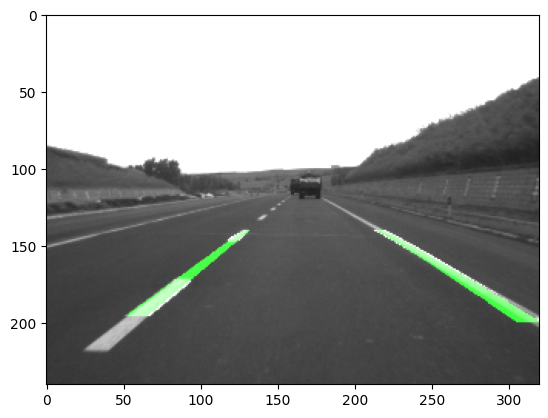

In [67]:
points=[[230,150],[140,150],[326,210],[39,205]]
pixel_density=(320,240)
widen_size=10
temp_path='./source/normal illumination/682.bmp'
im_temp=program(file_path=temp_path,pixel_density=pixel_density,widen_size=widen_size,points=points)
plt.imshow(im_temp)
cv2.imwrite('./multilane.jpg',im_temp)

In [44]:
#辅助程序
#通过鼠标点击显示鼠标位于图片中的像素点
# 回调函数

def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print("Pixel coordinates (x, y):", x, y)

# 读取图像
# image = cv2.imread('image.jpg')
image=get_images('./source/Intense illumination/436.bmp',pixel_density=(320,240))
image=widen_image(image,10)

# 创建窗口并绑定回调函数
cv2.namedWindow('Image')
cv2.setMouseCallback('Image', mouse_callback)

while True:
    # 显示图像
    cv2.imshow('Image', image)

    # 按下 'q' 键退出循环
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 释放窗口和销毁所有窗口
# cv2.destroyAllWindows()

Pixel coordinates (x, y): 194 132
Pixel coordinates (x, y): 150 132
Pixel coordinates (x, y): 207 141
Pixel coordinates (x, y): 140 141
Pixel coordinates (x, y): 326 210
Pixel coordinates (x, y): 39 205
